
# Portfolio Optimization with [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html)
--------
## Source code:
### [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html) documentation

### [Example](https://riskfolio-lib.readthedocs.io/en/latest/examples.html) codes

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import riskfolio.Portfolio as pf
import riskfolio.ConstraintsFunctions as cf
import riskfolio.PlotFunctions as plf
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Pandas_datareader override
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

In [4]:
# Select date range to pull asset prices
start = '2016-01-01'
end = '2020-08-16'

In [5]:
# Select asset tickers
assets = ['BRK-B','ARKK','AGG','ETH-USD']
assets.sort()

In [6]:
# Downloading data from yfinance
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  4 of 4 completed


In [7]:
# Calculate returns
Y = data[assets].pct_change().dropna()
display(Y.head())


,AGG,ARKK,BRK-B,ETH-USD
Date,,,,
2016-01-05,0.0463%,0.7996%,0.3824%,-0.4509%
2016-01-06,0.3796%,-1.6857%,0.0610%,0.0720%
2016-01-07,-0.0092%,-3.9334%,-1.4087%,-0.9313%
2016-01-08,0.2213%,-1.1548%,-0.8882%,4.7541%
2016-01-09,0.0000%,0.0000%,0.0000%,0.0045%


In [8]:
# Create constraints (you can create more detailed constraints - see example codes)
asset_classes = {'Assets': ['AGG', 'ARKK', 'BRK-B', 'ETH-USD'],
                 'Class 1': ['Fixed Income', 'Equity', 'Equity', 'Crypto'],
                }
asset_classes = pd.DataFrame(asset_classes)
constraints = pd.read_excel('/Users/draganbogatic/Documents/Fin_Tech/portfolio_optimization/resources/constraints.xls',  index_col='Index')
constraints

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
Index,,,,,,,,,,
0,False,Classes,Class 1,Equity,>=,60.0000%,nan%,nan%,nan%,nan%
1,False,Classes,Class 1,Fixed Income,<=,30.0000%,nan%,nan%,nan%,nan%
2,False,Classes,Class 1,Crypto,<=,3.0000%,nan%,nan%,nan%,nan%
3,False,Assets,NaN,BRK-B,>=,30.0000%,nan%,nan%,nan%,nan%
4,False,Assets,NaN,BRK-B,<=,50.0000%,nan%,nan%,nan%,nan%


In [9]:
A, B = cf.assets_constraints(constraints, asset_classes)
A,B

(array([[ 0,  1,  1,  0],
        [-1,  0,  0,  0],
        [ 0,  0,  0, -1],
        [ 0,  0,  1,  0],
        [ 0,  0, -1,  0]]),
 array([[ 0.6 ],
        [-0.3 ],
        [-0.03],
        [ 0.3 ],
        [-0.5 ]]))

In [29]:
# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data
method_cov='hist' # Method to estimate covariance matrix based on historical data
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

# Load constraints (you can optimize without constraints)
port.ainequality = A
port.binequality = B

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)


,AGG,ARKK,BRK-B,ETH-USD
weights,30.0000%,37.0000%,30.0000%,3.0000%


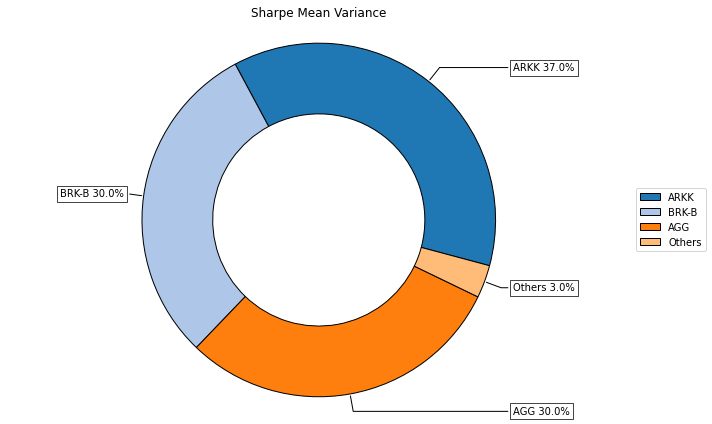

In [30]:
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20", height=6, width=10, ax=None)

In [31]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AGG,ARKK,BRK-B,ETH-USD
0,30.0000%,19.0004%,50.0000%,0.9996%
1,30.0000%,17.8699%,49.1301%,3.0000%
2,30.0000%,21.8756%,45.1244%,3.0000%
3,30.0000%,25.0344%,41.9656%,3.0000%
4,30.0000%,27.7431%,39.2569%,3.0000%


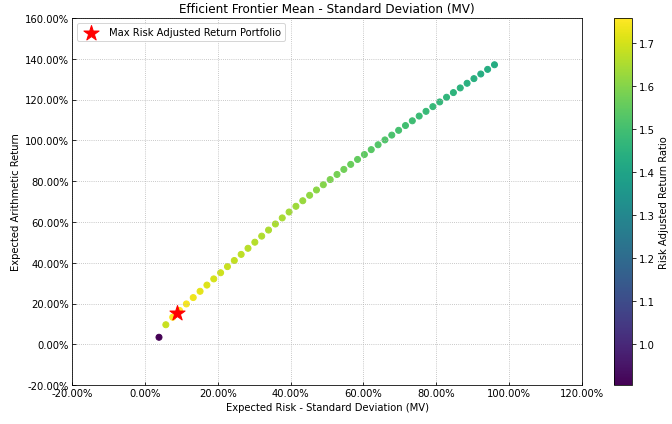

In [24]:
# Plotting the efficient frontier in Std. Dev. dimension
label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

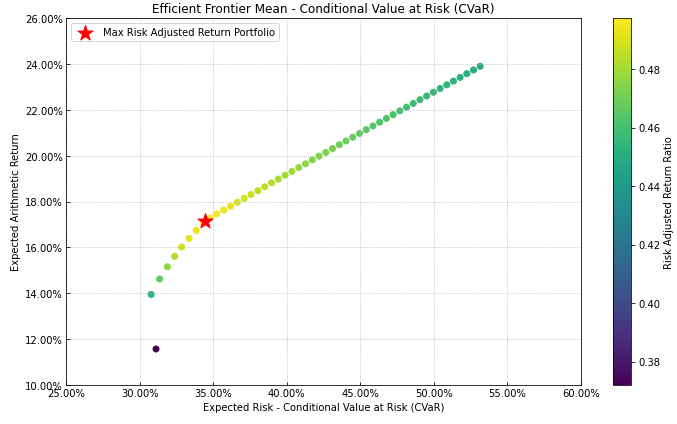

In [32]:
# Plotting the efficient frontier in CVaR dimension
ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='CVaR',
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

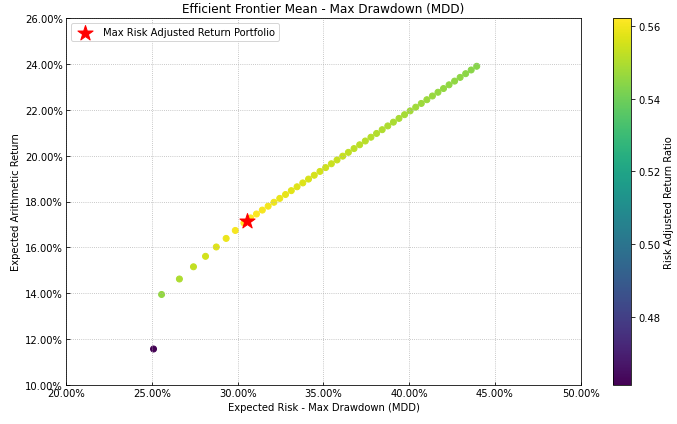

In [33]:
# Plotting the efficient frontier in Max Drawdown dimension
ax = plf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='MDD',
                       rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                       marker='*', s=16, c='r', height=6, width=10, ax=None)

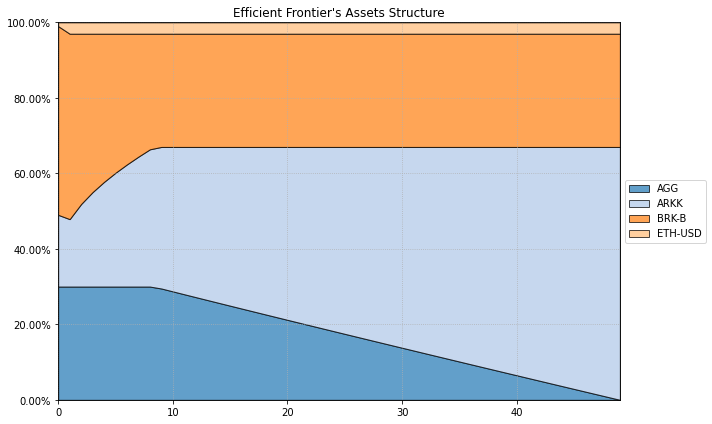

In [34]:
# Plotting efficient frontier composition

ax = plf.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [35]:
# See portfolio composition by asset
w_classes = pd.concat([asset_classes.set_index('Assets'), w], axis=1)

display(w_classes)

,Class 1,weights
Assets,,
AGG,Fixed Income,30.0000%
ARKK,Equity,37.0000%
BRK-B,Equity,30.0000%
ETH-USD,Crypto,3.0000%


In [66]:
# Risk Measures available:

# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
AGG,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,18.47%,12.07%,30.00%,30.00%,30.00%,30.00%,30.00%
ARKK,37.00%,37.00%,37.00%,37.00%,37.00%,37.00%,48.53%,54.93%,37.00%,37.00%,37.00%,37.00%,37.00%
BRK-B,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%,30.00%
ETH-USD,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%,3.00%
